In [76]:
%matplotlib inline

import os
import sys
import pywt
import numpy as np
from numpy import mean, sqrt, square, log10, isnan, isscalar, asscalar
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText


# filtering function definitions
def mad(data, axis=None):
    # median absolute deviation
    return np.median(np.absolute(data - np.median(data,axis)), axis)

def waveletSmooth(signal, wavelet, level=1):
    # returns y a rectified and smoothed signal
    
    # multilevel wavelet decomposition generates coefficients
    coeff = pywt.wavedec(signal, wavelet, mode="per") #by default last axis is used

    # calc a threshold to exclude outliers beyond one median absolute deviation of gaussian
    sigma = mad(coeff[-level])
    signal_len = len(signal)
    threshold = sigma * np.sqrt(2*np.log(signal_len))
    # Note: alternative distance metrics can be used to vary the threshold
    coeff[1:] =(pywt.threshold(i , value=threshold, mode="soft") for i in coeff[1:])
    #reconstruct signal
    y = pywt.waverec(coeff, wavelet, mode="per")
    return y
    
def rms(data):
    # returns the root mean squared amplitude of the data
    
    # check and fill any nan
    if np.isnan(data).any():
        data = data[~np.isnan(data).any(axis=1)]
    
    B = np.min(data)
    rms = sqrt(mean(square(data - B)))
    #print(rms)
        
    # convert nonscalar rms to a scalar float
    if ~isscalar(rms):
        #print('rms is nonscalar')
        rms = asscalar(rms)

    return rms
    
def signal_to_noise(signal, noise):
    # returns the signal to noise ratio
    # assumption: Equal impedance
   
    Asignal = rms(signal)
    Anoise = rms(noise)
    
    #if ~isscalar(Anoise):
    #    print('Anoise is nonscalar')
    #    break
    
    if Anoise == 0:
        SNRdb = float('nan')
    else:
        SNRdb = 10*-log10((Asignal/Anoise)**2)

    return SNRdb

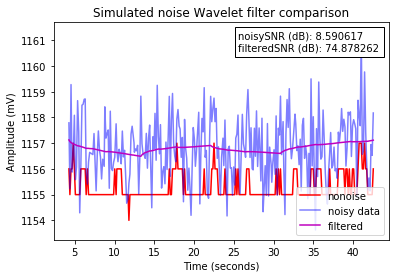

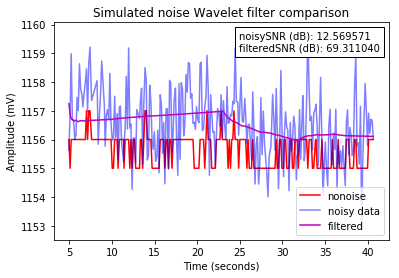

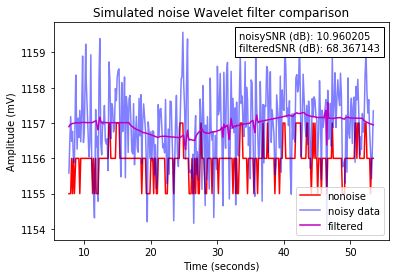

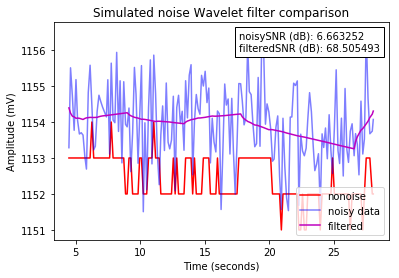

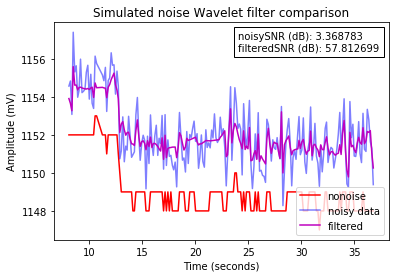

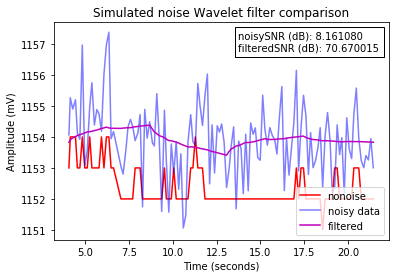

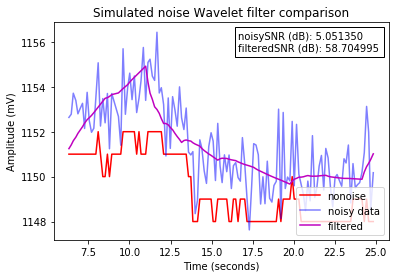

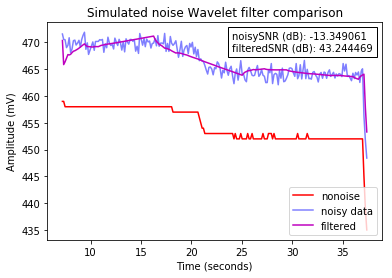

c:\users\anna\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel\__main__.py:65: RuntimeWarning: divide by zero encountered in log10


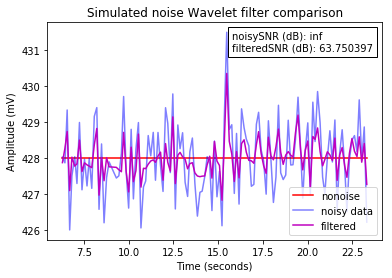

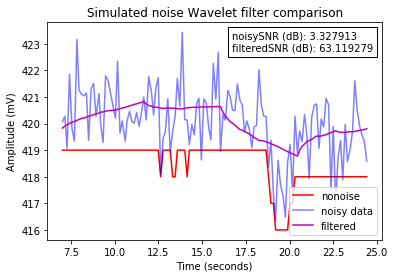

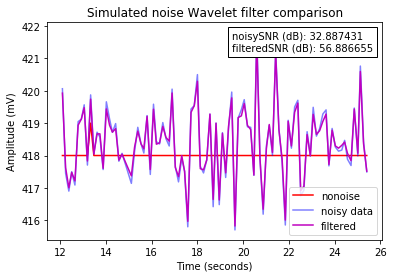

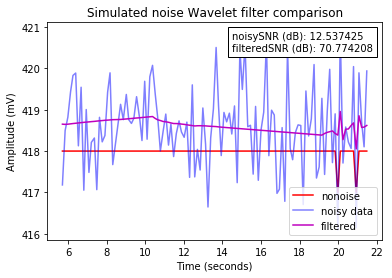

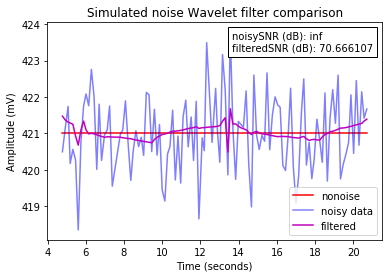

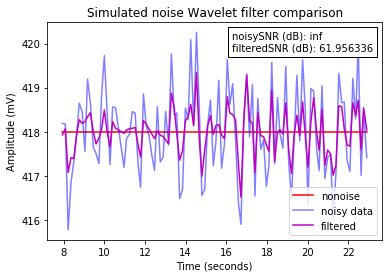

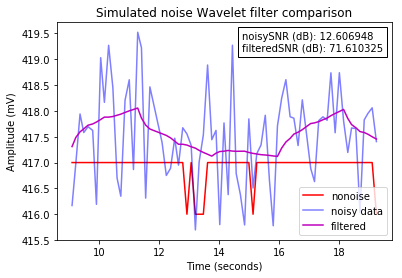

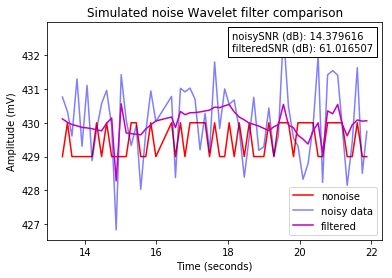

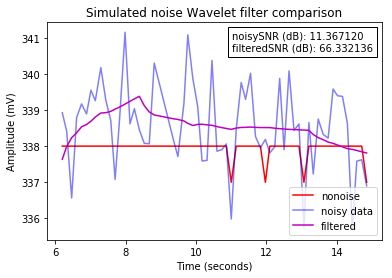

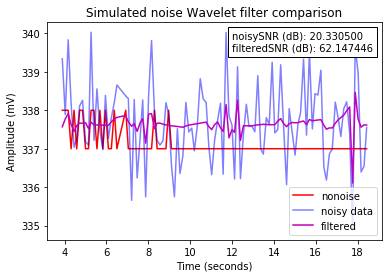

In [81]:
# Simulated noise comparative verification of Wavelet Filter
# no noise signal vs simulated noise added to signal vs filtered signal
# Author: Anna Lu
# Modified: May 1, 2017

cwd = os.getcwd() + "\\"
nomotion_signal_path = cwd

for filename in os.listdir(nomotion_signal_path):
    signal = []
    if (filename.endswith('.nir')):

        ### fetch data as matrix from file
        data = np.genfromtxt(cwd + filename, delimiter=',')
        
        num_col = (data.shape[1])
        data = np.array(data[0:].T, dtype=np.float64)
        time = data[0]
        
        ### simulate addition of gaussian noise
        
        # select arbitrary nir column from a single wavelength to analyze
        col = 18
        
        datapkpk = abs(max(data[col]) - min(data[col]))
        
        pkpkmean = (datapkpk/2)
        
        #print(pkpkmean)
        
        noise = np.random.normal(pkpkmean, 1, np.size(data[1:]))

            # pkpkmean is the mean peak to peak where the normal distribution centered to pkpkmean
            # 1 is the standard deviation of the normal distribution
            # sqauared size of data = number of elements 
        
        # reshape and add to data except time
        # data[1:]
        noise = np.reshape(noise, data[1:].shape)
        noisydata = data[col] + noise
             
        ### wavlet filter
        wavelet_type = 'db2' # Two decomposition discrete Daubechies wavelet mapping
        #noisydataCOL = np.array(noisydata[col], dtype=np.float64)
        filtdata = waveletSmooth(noisydata[col], wavelet_type, level=5) # smoothing level
        
        # correct dimension mismatch
        if(np.shape(filtdata) != np.shape(noisydata[col])):
            filtdata = filtdata[:-1]
            
        # Signal to noise ratio calculations
        # raw no motion data with simulated gaussian noise
        noisySNR = signal_to_noise(data[col], noise) #noisydata[col])
        
        # filtered noise for SNR comparison
        filterednoise = (filtdata - data)
        
        filtSNR = signal_to_noise(filtdata, filterednoise)
        # filtSNR = signal_to_noise(filtdata[col], noise)
        SNR_report = ('noisySNR (dB): %f\nfilteredSNR (dB): %f' %(noisySNR, filtSNR))

        #print(type(filtSNR))
        # visualize no noise vs simulated noise vs filter
        comp = 'Simulated noise Wavelet filter comparison'
        f, ax = plt.subplots(1,1)
        plt.title(comp)
        plt.ylabel('Amplitude (mV)')
        plt.xlabel('Time (seconds)')
        p1, = plt.plot(time, data[col], color='r', label='nonoise')
        p2, = plt.plot(time, noisydata[col], color='b', alpha=0.5, label='noisy data')
        p3, = plt.plot(time, filtdata, color='m', label='filtered')
        #plt.annotate(SNR_report, xy=(1.05, 0.8))
        txt = AnchoredText(SNR_report, loc=1)
        ax.add_artist(txt)
        plt.legend(handles=[p1, p2, p3], loc=4)
        plt.show()